In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn import preprocessing

from google.colab import drive
drive.mount('/content/drive')

GOOGLE_DRIVE_BASE_PATH = "/content/drive/MyDrive/"
user = "Matthew" # change before running the notebook

if user == "Julia":
    DATA_PATH = GOOGLE_DRIVE_BASE_PATH + "ER131-Project/" + "data/"
elif user == "Matthew":
    # DATA_PATH = "/Users/mdong/dataScience/projects-ml/ca-waste/" + "data/"
    DATA_PATH = GOOGLE_DRIVE_BASE_PATH + "Sustainability/ER131-Project/" + "data/"
elif user == "Samadi":
    DATA_PATH = GOOGLE_DRIVE_BASE_PATH + "ER131-Project/" + "data/"
elif user == "Shaye":
    DATA_PATH = GOOGLE_DRIVE_BASE_PATH + "ER131-Project/" + "data/"
    
print("User: {}\nPath to data: {}".format(user, DATA_PATH))

Mounted at /content/drive
User: Matthew
Path to data: /content/drive/MyDrive/Sustainability/ER131-Project/data/


#**1.8 Forecasting and Prediction Modeling**

## Load in data

In [ ]:
complete_feature_df = pd.read_csv(DATA_PATH + "complete_feature_df.csv")
complete_feature_df.head()

Year  Waste Produced (Tons)  ... Multi-Family (units)  Single Family (units)
0  2000.0             1676429.25  ...               203132                 328399
1  2000.0                 745.00  ...                  561                    883
2  2000.0               41059.90  ...                  913                  12563
3  2000.0              203896.87  ...                17317                  53845
4  2000.0               34110.44  ...                  856                  19777

[5 rows x 9 columns]

In [ ]:
complete_feature_df.set_index("Year", inplace=True)
complete_feature_df.head(3)

Waste Produced (Tons)  ... Single Family (units)
Year                           ...                      
2000.0             1676429.25  ...                328399
2000.0                 745.00  ...                   883
2000.0               41059.90  ...                 12563

[3 rows x 8 columns]

## Feature, target split

In [ ]:
target = complete_feature_df[["Waste Produced (Tons)"]]
feature_df = complete_feature_df.drop(columns="Waste Produced (Tons)")
feature_df.head(2)

County  Population  ...  Multi-Family (units)  Single Family (units)
Year                         ...                                             
2000.0  Alameda   1443939.0  ...                203132                 328399
2000.0   Alpine      1208.0  ...                   561                    883

[2 rows x 7 columns]

In [ ]:
target.head(2)

Waste Produced (Tons)
Year                         
2000.0             1676429.25
2000.0                 745.00

## Preprocessing

### One hot encoding


We would like to include the county as a categorical feature in our model, so we will one hot encode the features. While it is usually common practice to have k-1 one hot encoded columns , in our case number of counties-1, to avoid collinearity we decided for the regression methods we are using it is best to keep full rank. In regularized regression, the intercept coefficient is not penalized, so if you are inferring the effect of a level as not part of the intercept, its hard to say you are penalizing all levels equally. For this reason, we include all the levels, so each is symmetric with respect to the penalty.

However, we acknowledge the issue of multicollinearlity from keeping all k levels for the OLS model. This might cause OLS to perform worse than the regularization methods given the same data frame and may lower our confidence our choice of the optimal model.


In [ ]:
feature_df = pd.get_dummies(feature_df, columns=["County"])#, drop_first = True)
feature_df.head()

Population  ...  County_Yuba
Year                ...             
2000.0   1443939.0  ...            0
2000.0      1208.0  ...            0
2000.0     35100.0  ...            0
2000.0    203171.0  ...            0
2000.0     40554.0  ...            0

[5 rows x 63 columns]

## Train test split

In [ ]:
feature_df.head()

Population  ...  County_Yuba
Year                ...             
2000.0   1443939.0  ...            0
2000.0      1208.0  ...            0
2000.0     35100.0  ...            0
2000.0    203171.0  ...            0
2000.0     40554.0  ...            0

[5 rows x 63 columns]

80% training 20% test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(feature_df, target, test_size=0.2, random_state=42)

In [ ]:
X_train.head(3)

Population  ...  County_Yuba
Year                ...             
2014.0    261001.0  ...            0
2012.0   2244472.0  ...            0
2018.0     44595.0  ...            0

[3 rows x 63 columns]

In [ ]:
y_train.head(3)

Waste Produced (Tons)
Year                         
2014.0              177022.31
2012.0             1744578.50
2018.0                3439.56

# Part 1: Predicting waste generation for a given California county over the course of one year  


## Model selection training on the entire dataset

The goal of both prediction questions 1 and 2 is to predict the amount of waste produced by a given county in California over the course of a year. Prediction question 1 trains a model on all county data over the years 2000-2019, while prediction question 2 trains a model on data from one individual county between 2000-2019. Our motiviation for asking these questions is to understand how scope might effect the predictive power of OLS, Lasso, Ridge, Elastic Net, and Random Forest Decisions Trees when predicting total waste generation in a given California county. In comparing the performance of these models we aim to answer the following questions:

- Does understanding the behavior of waste generation in a given year across the state of California as a whole improve our predictions of waste generation for a specific county? 

- More generally, narrowly specific research questions often have less relevant data available to answer them. Is the trade off between data quantity and questions of a smaller scope reasonable when making predictive models? 

To compare linear regression models to random forests decision trees, we have implemented multiple rounds of model selection using cross validation. Firstly, for our linear regression models, we have tuned hyperparameters (alpha) using cv to find the optimal model for a given method (OLS, Ridge, Lasso, Elastic Net). We then compared the best cross validated scores between each model to select the best performing linear regression model. A similar process for tuning was used for random forests. Random forests and the best linear model were then compared using the testing data set. We used the best performing model of these two options to predict on the entire data set.

## Linear regression methods

We have fit our data to least squares, ridge, lasso, and elastic net regression. Ordinary least squares regression does not use any regularization, so we do not need do tune any hyperparameters on this model. However, we do need to tune the alpha hyperparameter used to fit the ridge, lasso, and elastic net models. In the scikit packages, alpha is the lambda value of the regularization term (larger values equate to a larger penalty for large coefficient values). Tuning this hyperparameter prevents the model from overfitting, thus balancing the bias variance trade off.  

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV

As mentioned above, for each model that uses regularization, we have found the optimal lambda value which minimizes the model's mse. We have used scikit packages to perform cross validation on a list of alpha values, and subsequently fit the model using the optimal alpha identified. 


**Justification for parameter inputs:**


* **CV**: For this prediction question, we are training on the full data set (all counties over the years 2000-2019). The training data set consists of ~900 observations, which we believe is large enough to use k-fold CV rather than LOOCV. We chose the standard k=5 which will split the training data into 5 splits (roughly replicating the 80% 20% train test split of out data). For each fold a different split of the data is used as the test set while the rest is used to train the model. The 5 errors are then averaged and is used as the score of the model for the given alpha value
* **GridSearchCV** This package performs a GridSearch and chooses the alpha whose model had lowest mae error which is specified as the scoring input.
* **alpha**: we have tested alpha values from 0 to 5 for ridge regression. With so few features, a high penality/large alpha is not necessary. If alpha is too large, the model may be underfit. For lasso, we expected low values of alpha, as lasso can perform feature selection. According to online resources, lasso is generally optimized ~ 1/# observations ~ 1/1000. However, we found smaller values of alpha were failing to converge while very large values of alpha scored better. This would suggest the data does not have many meaningful features. Upon reflection, having the one hot encoded features for each county might be the reason such a large alpha is needed to eliminate the coefficients. 
* **normalize**: we must normalize the features for models that use regularization in order to prevent features with a large range, such as housing units, from dominating the equation.
* **scorer**: the models have been scored using mean absolute error. We believe this is a good loss function because MAE is more robust to outliers (does not penalize as harshly for large differences). In our data set, some counties vary significantly in the amount of waste they produce, creating outliers and a wide range of values. We used MAE to select the final model and the model's hyperparameter. Using MSE to tune and MAE is ineffective because a dataset containing a few extreme outliers in an MSE fitted equation can be pulled arbitrarily far away from the MAE equation.


In [ ]:
def score_cv_model(Model, X_train, y_train, X_test, y_test, alphas):
  """ The function fits a given model whose hyperparamteters have been tuned using k=5 fold cross validation to the
      inputted X and y training data then outputs the cross-validated mae score and the tuned model

      Model = model to fit the data on
      X_train = the training data feature matrix
      y_train = training data target variable (single column)
      X_test  = test data feature matrix
      y_test = test data target variable (single coulmn)
      alphas = an array of alpha values to perform the grid search on 
  """
  #splits the X_train data into 5 splits
  kf = KFold(n_splits = 5, shuffle = True)

  if Model == LinearRegression:
    modelcv = Model()
    modelcv.fit(X_train, y_train)
    #cv score on the training data 
    score = np.mean(cross_val_score(modelcv, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = kf )*-1)

  else:
    model = Model()
    modelcv = GridSearchCV(estimator = model, param_grid = alphas, scoring = 'neg_mean_absolute_error', cv = kf)
    modelcv.fit(X_train, y_train) 
    print(modelcv.best_estimator_)
    #cv score of the tuned regression model 
    score = modelcv.best_score_*-1

  return score, modelcv

In [ ]:
#defines the range of alpha values to perform the grid search for each kind of regression model 
ridge_alphas = {'normalize': [True],'alpha': np.arange(0.001,1,.0005), 'tol': [0.00001]}
lasso_alphas = {'normalize': [True],'alpha': np.arange(1,50,1), 'max_iter': [100000]}
en_alphas = {'normalize': [True], 'alpha': np.arange(.1,5,.5), 'l1_ratio': np.arange(0.01,1,0.01),'max_iter': [100000]}

In [ ]:
ols_score, ols = score_cv_model(LinearRegression, X_train, y_train, X_test, y_test, 0)
ridge_score, ridge = score_cv_model(Ridge, X_train, y_train, X_test, y_test, ridge_alphas) #correcting for the negative absolute error
lasso_score, lasso = score_cv_model(Lasso, X_train, y_train, X_test, y_test, lasso_alphas) #correcting for the negative absolute error
en_score, en = score_cv_model(ElasticNet, X_train, y_train, X_test, y_test, en_alphas) #correcting for the negative absolute error

print('cv ols score: ', ols_score)
print('cv ridge score: ', ridge_score)
print('cv lasso score: ', lasso_score)
print('cv elastic net score :', en_score)

Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=None, solver='auto', tol=1e-05)
Lasso(alpha=11, copy_X=True, fit_intercept=True, max_iter=100000,
      normalize=True, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.99,
           max_iter=100000, normalize=True, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
cv ols score:  101362.42556320918
cv ridge score:  93791.8602274529
cv lasso score:  90554.59941455028
cv elastic net score : 134055.68300373154


Of the linear regression models, it seems that lasso regression performs the best. To select our final model, we compared the test error for the lasso regression model and the random forest model.

## Decision tree ensemble method

- Note: Decision trees are supposed to be able to handle categorical features but this is [not supported in sklearn](https://stackoverflow.com/questions/38108832/passing-categorical-data-to-sklearn-decision-tree) so we need to one hot encode

In [ ]:
random_forest_model = RandomForestRegressor()

possible_hyperparams = { 
    'n_estimators': [25, 50],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,10)]
}

grid_search = GridSearchCV(estimator=random_forest_model, param_grid=possible_hyperparams, cv=5, scoring='neg_mean_absolute_error')

In [ ]:
grid_search.fit(X_train, y_train.values.ravel()) # need to call this ravel function because of https://stackoverflow.com/questions/34165731/a-column-vector-y-was-passed-when-a-1d-array-was-expected
rf_best_score = -grid_search.best_score_ # needs to be negated because of https://stackoverflow.com/questions/21443865/scikit-learn-cross-validation-negative-values-with-mean-squared-error
best_rf_model = grid_search.best_estimator_
print('best rf model:', best_rf_model)
print('best random forest cv score: ', rf_best_score)

best rf model: RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=9, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
best random forest cv score:  59224.23720330016


## Comparing final models

In [ ]:
def model_test_score(model, X_train, y_train):
  model.fit(X_train, y_train.values.ravel())
  y_pred = model.predict(X_test)

  residual = y_pred - y_test.to_numpy().flatten()
  mae = mean_absolute_error(y_test,y_pred)

  return mae, residual, y_pred

In [ ]:
ols_test, ols_res, ols_y = model_test_score(ols, X_train, y_train)
ridge_test, ridge_res, ridge_y = model_test_score(ridge, X_train, y_train)
lasso_test, lasso_res, lasso_y = model_test_score(lasso, X_train, y_train)
en_test, en_res, en_y = model_test_score(en, X_train, y_train)
rf_tree_test, rf_tree_res, rf_tree_y = model_test_score(best_rf_model, X_train, y_train)

print('ols test score: ', ols_test)
print('ridge test score: ',ridge_test)
print('lasso test score: ',lasso_test)
print('elastic net test score: ',en_test)
print('random forest tree test score: ',rf_tree_test)

ols test score:  81396.54958893513
ridge test score:  79909.7392343085
lasso test score:  75830.5712182989
elastic net test score:  114219.12198183598
random forest tree test score:  46382.1651203037


The random forest tree has the lowest MAE so we chose it as our best performing model. Random forest performing as the best model implies that our features have a non-linear relationship with the target variable. Out of curiosity, we also calculated the residuals, predicted y values, and tested MAE for all of the models. We later plotted the predicted y values and residuals to help visualize the difference between each model.

It can also be beneficial to compare cross validated MAE to test MAE. A large discrepency in MAE and test error may suggest the model is overfitting. 

In [ ]:
print('Difference between cv MAE and test MAE')
print('ols: ',ols_score - ols_test)
print('ridge: ', ridge_score - ridge_test)
print('lasso: ',lasso_score-lasso_test)
print('en: ', en_score - en_test)
print('rf: ', rf_best_score - rf_tree_test)

Difference between cv MAE and test MAE
ols:  19965.87597427405
ridge:  13882.120993144403
lasso:  14724.028196251384
en:  19836.561021895555
rf:  12842.072082996456


Random forests also has the smallest difference between cross validated training MAE and test MAE, making it a very strong candidate as the best performing model.

## Plot of errors for each model



The following plot is a violin plot of the errors for each model. The violin plot will show the distribution of errors, with a larger distribution indicating more variance in the model, and errors concentrated on the ends of the distribution implying more bias (larger error values).

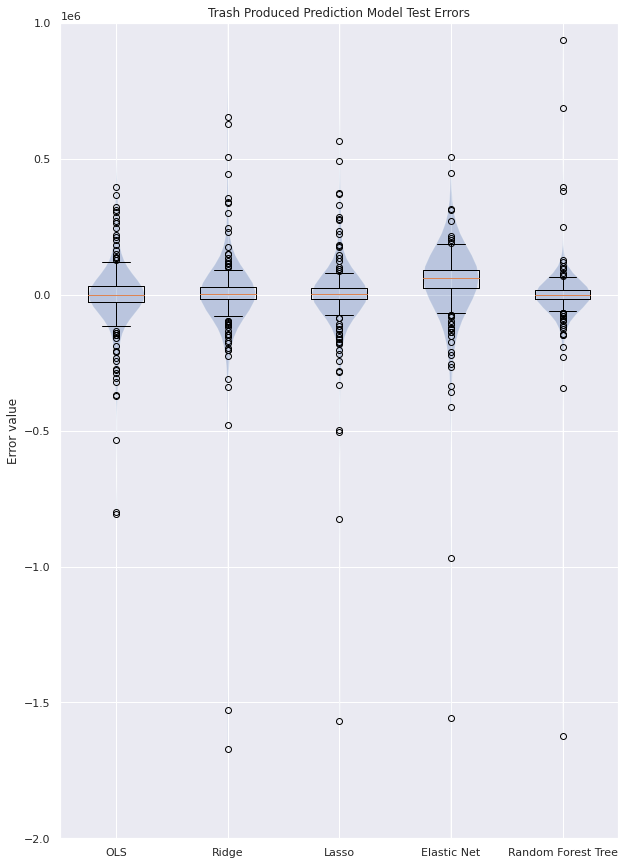

In [ ]:
data = [ols_res,ridge_res,lasso_res,en_res,rf_tree_res]

fig, ax = plt.subplots(figsize=(10,15))

ax.set_title('Trash Produced Prediction Model Test Errors')
ax.set_ylabel('Error value')
xticklabels=['OLS','Ridge', 'Lasso', 'Elastic Net','Random Forest Tree']
ax.set_xticklabels(xticklabels)
plt.ylim(-2*10**6,1*10**6)
ax.boxplot(data, autorange=False)
ax.violinplot(data, showextrema=False)
plt.show()

Based on the violin plot, the OLS model seems to have the most bias, with errors concentrated around larger values. Elastic net seems to have the widest distribution, implying it has more variance.

The following is a plot of the residuals vs. electricity usage. The residuals should have no relationship with the x features.

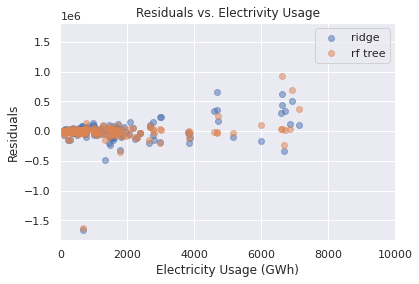

In [ ]:
plt.scatter(x = X_test.iloc[:,2], y = ridge_res, label = 'ridge', alpha = 0.5)
plt.scatter(x = X_test.iloc[:,2], y = rf_tree_res, label = 'rf tree', alpha = 0.5)
plt.xlabel('Electricity Usage (GWh)')
plt.ylabel('Residuals')
plt.xlim(0,10000)
#plt.ylim(2*10**6,-2*10**6)
plt.legend()
plt.title('Residuals vs. Electrivity Usage')
plt.show();

It appears that our model might be predicting worse for higher electricity usage.

The following code plots the actual vs. predicted trash produced for the full data set and test data set for each of the models. 

In [ ]:
def plot_model_prediction(model, X, y, label):
  model.fit(X_train, y_train.values.ravel())
  y_pred = model.predict(X)
  plt.scatter(y_pred,y, label = label, alpha = 0.5)

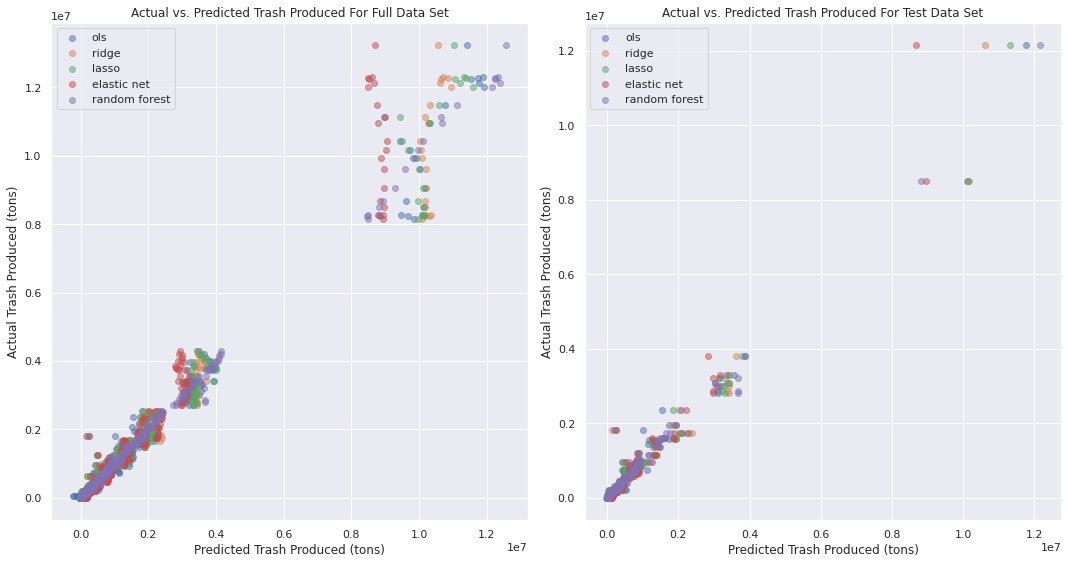

In [ ]:
models = {'ols': ols, 'ridge': ridge, 'lasso': lasso, 'elastic net': en, 'random forest': best_rf_model }

plt.figure(figsize=(15,8))
#plotting the actual vs. predicted values for each model predicting on the full data set
plt.subplot(121)
for model in models.keys():
  plot_model_prediction(models[model], feature_df, target, model)
plt.legend()
plt.xlabel('Predicted Trash Produced (tons)')
plt.ylabel('Actual Trash Produced (tons)')
plt.title('Actual vs. Predicted Trash Produced For Full Data Set');

#plotting actual v. predicted models predicting on the test data set
plt.subplot(122)
for model in models.keys(): 
  plot_model_prediction(models[model], X_test, y_test,model)

plt.legend()
plt.xlabel('Predicted Trash Produced (tons)')
plt.ylabel('Actual Trash Produced (tons)')
plt.title('Actual vs. Predicted Trash Produced For Test Data Set')
plt.tight_layout()
plt.show();

From this plot, we can see the random forest decision tree is the best model. It is hard to compare the linear models based on this scatter plot, however we do see that all the models seem to not predict as well for large values of trash produced.

## Using best model to predict waste generated by Alameda and Tulare



To help visualze our model's performance for specific counties, we plotted the predicted waste generation in Alameda and Tulare county for each year from 2000-2019 against total observed waste (tons).

In [ ]:
best_model = best_rf_model

In [ ]:
best_model.fit(feature_df, target.values.ravel())
complete_feature_df["Predicted Waste Produced"] = best_model.predict(feature_df)
complete_feature_df.reset_index(inplace=True)
complete_feature_df.rename(columns={"Waste Produced (Tons)": "Observed Waste Produced"}, inplace=True)
predictions_observations = complete_feature_df[["Year", "County", "Observed Waste Produced", "Predicted Waste Produced"]]
predictions_observations.head()

Year     County  Observed Waste Produced  Predicted Waste Produced
0  2000.0    Alameda               1676429.25              1.519888e+06
1  2000.0     Alpine                   745.00              2.155320e+03
2  2000.0     Amador                 41059.90              3.742792e+04
3  2000.0      Butte                203896.87              2.457080e+05
4  2000.0  Calaveras                 34110.44              4.020522e+04

In [ ]:
def generate_prediction_plot(df, county):
    """Generates plotly line chart for a given county depicting observed waste trends
    and predicted values
    """
    county_preds_obs = county_preds_obs = df[df.County == county]
    observations = county_preds_obs["Observed Waste Produced"]
    predictions = county_preds_obs["Predicted Waste Produced"]

    fig = go.FigureWidget(data=[
      go.Scatter(x=county_preds_obs.Year, y=observations, 
                  mode='lines', line={'dash': 'solid'}, name="Observed"),
      go.Scatter(x=county_preds_obs.Year, y=predictions, 
                  mode='lines', line={'dash': 'dash'}, name="Predicted")
    ])
    fig.update_xaxes(title_text='Year')
    fig.update_yaxes(title_text='Waste Produced (Tons)')
    fig.update_layout(title=county + " Observed and Predicted Values")
    return fig

In [ ]:
fig = generate_prediction_plot(predictions_observations, "Alameda")
fig.show()

In [ ]:
fig = generate_prediction_plot(predictions_observations, "Tulare")
fig.show()

Random Forests does a pretty good job of predicting waste generation in Alameda county, at the risk of possibly overfitting the data. The predictions for Tulare county seem to be much less accurate.

# Error Analysis and Limitations 
**Potential Errors from one-hot encoding in our models:**

* Significantly increased the size of our data frame, which in general is not ideal for machine learning problems as it can easily lead to overfit and high variance. 
*   Our encoded feature is counties, of which there are 57 unique values in the data set, which is relatively high cardinality. This created high variability in error between folds in our model as the test set might have included counties that were not present in the training set. 
* Upon reflection, it is not surprising that the tuned random forest tree performed the best because decision trees are more tolerant to categorical variables. However, high cardinality could have caused unique issues for the random forest tree model as well. Generating numerical dummy variables, might not have been practical because the number of possible splits grows non linearly with cardinality again leading to overfit and high variance. In addition, by one-hot encoding a categorical variable, we are inducing sparsity into the dataset which is undesirable. Furthermore, continuous variables will be given more importance than the dummy variables by the algorithm which will obscure the order of feature importance resulting in poorer performance.

When constructing our model, we believed it would be beneficial to have the county as a feature because the amount of trash produced is likely to vary by county. For example, this category might be able to capture information that is not included in our data frame like some counties having larger budgets or being physically larger. We also did not anticipate high cardinality to have such a large impact because each county should appear the same number of times in the full data set, however, it caused variability with the test train splits. In the future, our models could probably be improved by likelihood encoding, which substitutes each category by the average presence of the target in each category. Another alternative could be to include special groupings to preserve categorical variables when using lasso and elastic net regression. This could possibly help with the problem of high cardinality and overfit. We did not explore this option due to the limited time and scope of this project.

**Problems with using MAE loss to optimize lasso and elastic net parameters**

Throughout this modeling process, we ran into convergence errors when trying to tune the hyperparameters for lasso and elastic net regression. It is possible we were unable to converge because we used MAE as our loss function which is not differentiable and may not have a minimum value to converge to. The error suggested we increase the maximum number of iterations and make the tolerance lower. While this might remedy the error, increasing the number of iterations can be problematic for 2 reasons. First, increasing the iterations dramtically increased the run time. Second, this could lead to significant overfit of our models. We know that high values of alpha can underfit the model, but on the flip side, kicking the max iterations up runs the risk of over tuning hyperparameters to the training data.

---

---

# Part 2: Predicting waste generation for a given California county over the course of one year

##Model selection training on an **individual** county's dataset

For prediction question 1, we predicted the amount of waste produced by a given county in California over the course of a year by training on data from all counties within the state. For prediction question 2, we will train our models on data from only one individual county between 2000-2019. 

Do least squares, ridge, lasso, elastic net regression, and random forest decision trees better predict waste generation for a given county when trained on the full dataset or data from one individual county? To answer this question, we have carried out the same process from Part 1 on data from Alameda and Tulare county separately. Ultimately, the prediction graphs produced in Part 1 can be compared to the same graphs in Part 2, which were produced using data from only the county for which predictions are being made.

##Select County Data

In [ ]:
complete_feature_df = complete_feature_df.drop(columns=["Predicted Waste Produced"])
complete_feature_df.rename(columns={"Observed Waste Produced" : "Waste Produced (Tons)"}, inplace=True)
complete_feature_df.set_index("Year", inplace=True)
complete_feature_df.head(3)

Waste Produced (Tons)  ... Single Family (units)
Year                           ...                      
2000.0             1676429.25  ...                328399
2000.0                 745.00  ...                   883
2000.0               41059.90  ...                 12563

[3 rows x 8 columns]

In [ ]:
alameda_county_df = complete_feature_df.loc[complete_feature_df["County"] == 'Alameda']
alameda_county_df.head()

Waste Produced (Tons)  ... Single Family (units)
Year                           ...                      
2000.0             1676429.25  ...                328399
2001.0             1629208.38  ...                332390
2002.0             1596803.00  ...                335234
2003.0             1585190.61  ...                338009
2004.0             1692478.59  ...                340095

[5 rows x 8 columns]

In [ ]:
tulare_county_df = complete_feature_df.loc[complete_feature_df["County"] == 'Tulare']
tulare_county_df.head()

Waste Produced (Tons)  ... Single Family (units)
Year                           ...                      
2000.0              324877.46  ...                 92277
2001.0              321266.80  ...                 93524
2002.0              334878.36  ...                 95010
2003.0              361310.10  ...                 96587
2004.0              384676.32  ...                 98389

[5 rows x 8 columns]

##Feature, Target Split for Alameda and Tulare

In [ ]:
alameda_target = alameda_county_df[["Waste Produced (Tons)"]]
alameda_feature_df = alameda_county_df.drop(columns=["Waste Produced (Tons)", "County"])
alameda_feature_df.head(2)

Population  ...  Single Family (units)
Year                ...                       
2000.0   1443939.0  ...                 328399
2001.0   1457185.0  ...                 332390

[2 rows x 6 columns]

In [ ]:
alameda_target.head(2)

Waste Produced (Tons)
Year                         
2000.0             1676429.25
2001.0             1629208.38

In [ ]:
tulare_target = tulare_county_df[["Waste Produced (Tons)"]]
tulare_feature_df = tulare_county_df.drop(columns=["Waste Produced (Tons)", "County"])
tulare_feature_df.head(2)

Population  ...  Single Family (units)
Year                ...                       
2000.0    368021.0  ...                  92277
2001.0    371479.0  ...                  93524

[2 rows x 6 columns]

In [ ]:
tulare_target.head(2)

Waste Produced (Tons)
Year                         
2000.0              324877.46
2001.0              321266.80

## Train, Test Split for Alameda & Tulare

In [ ]:
X_train_alameda, X_test_alameda, y_train_alameda, y_test_alameda = train_test_split(alameda_feature_df, alameda_target, test_size=0.2, random_state=12)

In [ ]:
X_train_alameda.head(3)

Population  ...  Single Family (units)
Year                ...                       
2014.0   1590729.0  ...                 357504
2016.0   1632599.0  ...                 359987
2010.0   1510271.0  ...                 353242

[3 rows x 6 columns]

In [ ]:
y_train_alameda.head(3)

Waste Produced (Tons)
Year                         
2014.0             1106585.54
2016.0             1188438.89
2010.0             1152323.90

In [ ]:
X_train_tulare, X_test_tulare, y_train_tulare, y_test_tulare = train_test_split(tulare_feature_df, tulare_target, test_size=0.2, random_state=12)

In [ ]:
X_train_tulare.head(3)

Population  ...  Single Family (units)
Year                ...                       
2014.0    458492.0  ...                 113212
2016.0    465544.0  ...                 115111
2010.0    442179.0  ...                 110609

[3 rows x 6 columns]

In [ ]:
y_train_tulare.head(3)

Waste Produced (Tons)
Year                         
2014.0              330722.30
2016.0              374898.10
2010.0              311870.94

##Linear regression methods

**Justification for parameter inputs:**


* **CV**: For this prediction question, we are training on a small subset of the data set (only one California county from 2000-2019). Due to the dimished size of the training data set, we will use LOOCV rather than k-fold Cross Validation. 
* **scorer**: the models in Part 1 were scored using mean absolute error, so we will also use MAE in Part 2 to keep the scoring metric consistent. While MAE is generally better for larger datasets with outliers, we will ultimately compare the individual county models with the models trained on the entire dataset. 



In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV

def score_cv_model_2(Model, X_train, y_train, X_test, y_test, alphas):
  """ The function fits a given model whose hyperparamteters have been tuned using LOOCV to the
      inputted X and y training data then outputs the cross-validated MAE score and the tuned model

      Model = model to fit the data on
      X_train = the training data feature matrix
      y_train = training data target variable (single column)
      X_test  = test data feature matrix
      y_test = test data target variable (single coulmn)
      alphas = an array of alpha values to perform the grid search on 
  """

  if Model == LinearRegression:
    modelcv = Model()
    modelcv.fit(X_train, y_train)
    #cv score on the training data 
    score = np.mean(cross_val_score(modelcv, X_train, y_train, scoring = 'neg_mean_absolute_error')*-1)

  else:
    model = Model()
    modelcv = GridSearchCV(estimator = model, param_grid = alphas, scoring = 'neg_mean_absolute_error')
    modelcv.fit(X_train, y_train) 
    print(modelcv.best_estimator_)
    #cv score of the tuned regression model 
    score = modelcv.best_score_*-1

  return score, modelcv

In [ ]:
#defines the range of alpha values to perform the grid search for each kind of regression model 
ridge_alphas = {'normalize': [True],'alpha': np.arange(0.001,1,.0005), 'tol': [0.00001]}
lasso_alphas = {'normalize': [True],'alpha': np.arange(1,50,1), 'max_iter': [100000]}
en_alphas = {'normalize': [True], 'alpha': np.arange(.1,5,.5), 'l1_ratio': np.arange(0.01,1,0.01),'max_iter': [100000]}

Alameda Scores

In [23]:
ols_score_alameda, ols = score_cv_model_2(LinearRegression, X_train_alameda, y_train_alameda, X_test_alameda, y_test_alameda, 0)
ridge_score_alameda, ridge = score_cv_model_2(Ridge, X_train_alameda, y_train_alameda, X_test_alameda, y_test_alameda, ridge_alphas) #correcting for the negative absolute error
lasso_score_alameda, lasso = score_cv_model_2(Lasso, X_train_alameda, y_train_alameda, X_test_alameda, y_test_alameda, lasso_alphas) #correcting for the negative absolute error
en_score_alameda, en = score_cv_model_2(ElasticNet, X_train_alameda, y_train_alameda, X_test_alameda, y_test_alameda, en_alphas) #correcting for the negative absolute error

print('cv ols score for Alameda county: ', ols_score_alameda)
print('cv ridge score for Alameda county: ', ridge_score_alameda)
print('cv lasso score for Alameda county: ', lasso_score_alameda)
print('cv elastic net score for Alameda county:', en_score_alameda)

Ridge(alpha=0.007, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=None, solver='auto', tol=1e-05)
Lasso(alpha=49, copy_X=True, fit_intercept=True, max_iter=100000,
      normalize=True, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.99,
           max_iter=100000, normalize=True, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
cv ols score for Alameda county:  197778.1885981392
cv ridge score for Alameda county:  118061.9353046099
cv lasso score for Alameda county:  171305.64901373998
cv elastic net score for Alameda county: 124213.24228840652


Tulare Scores

In [24]:
ols_score_tulare, ols = score_cv_model_2(LinearRegression, X_train_tulare, y_train_tulare, X_test_tulare, y_test_tulare, 0)
ridge_score_tulare, ridge = score_cv_model_2(Ridge, X_train_tulare, y_train_tulare, X_test_tulare, y_test_tulare,ridge_alphas) #correcting for the negative absolute error
lasso_score_tulare, lasso = score_cv_model_2(Lasso, X_train_tulare, y_train_tulare, X_test_tulare, y_test_tulare, lasso_alphas) #correcting for the negative absolute error
en_score_tulare, en = score_cv_model_2(ElasticNet, X_train_tulare, y_train_tulare, X_test_tulare, y_test_tulare, en_alphas) #correcting for the negative absolute error

print('cv ols score for Tulare county: ',ols_score_tulare)
print('cv ridge score for Tulare county: ', ridge_score_tulare)
print('cv lasso score for Tulare county: ', lasso_score_tulare)
print('cv elastic net score for Tulare county:', en_score_tulare)

Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=None, solver='auto', tol=1e-05)
Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=100000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)
ElasticNet(alpha=4.6, copy_X=True, fit_intercept=True, l1_ratio=0.01,
           max_iter=100000, normalize=True, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
cv ols score for Tulare county:  34098.43499067197
cv ridge score for Tulare county:  34538.99508184117
cv lasso score for Tulare county:  34112.719294268325
cv elastic net score for Tulare county: 49124.9908076376


Of the linear regression models, it seems that Ridge might perform best, with the lowest score. To select our final model, we will compare the test error for the linear regression models to the Random Forest model.

## Decision tree ensemble method

In [ ]:
random_forest_model = RandomForestRegressor()

possible_hyperparams = { 
    'n_estimators': [10, 20],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,10)]
}

grid_search = GridSearchCV(estimator=random_forest_model, param_grid=possible_hyperparams, scoring='neg_mean_absolute_error')

grid_search.fit(X_train_alameda, y_train_alameda.values.ravel()) # need to call this ravel function because of https://stackoverflow.com/questions/34165731/a-column-vector-y-was-passed-when-a-1d-array-was-expected
rf_best_score_alameda = -grid_search.best_score_ # needs to be negated because of https://stackoverflow.com/questions/21443865/scikit-learn-cross-validation-negative-values-with-mean-squared-error
best_rf_model_alameda = grid_search.best_estimator_
print('best rf model for Alameda county:', best_rf_model_alameda)
print('best random forest cv score for Alameda county: ', rf_best_score_alameda)

Alameda Score

best rf model for Alameda county: RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
best random forest cv score for Alameda county:  49859.019533333325


Tulare Score

In [ ]:
grid_search.fit(X_train_tulare, y_train_tulare.values.ravel()) # need to call this ravel function because of https://stackoverflow.com/questions/34165731/a-column-vector-y-was-passed-when-a-1d-array-was-expected
rf_best_score_tulare = -grid_search.best_score_ # needs to be negated because of https://stackoverflow.com/questions/21443865/scikit-learn-cross-validation-negative-values-with-mean-squared-error
best_rf_model_tulare = grid_search.best_estimator_
print('best rf model for Tulare county:', best_rf_model_tulare)
print('best random forest cv score for Tulare county: ', rf_best_score_tulare)

best rf model for Tulare county: RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
best random forest cv score for Tulare county:  22036.19923333332


##Comparing final models

In [ ]:
def model_test_score(model, X_train, y_train, X_test, y_test):
  model.fit(X_train, y_train.values.ravel())
  y_pred = model.predict(X_test)

  residual = y_pred - y_test.to_numpy().flatten()
  mae = mean_absolute_error(y_test,y_pred)

  return mae, residual, y_pred

Alameda MAE, Residual, y_pred

In [ ]:
ols_test_alameda, ols_res_alameda, ols_y_alameda = model_test_score(ols, X_train_alameda, y_train_alameda, X_test_alameda, y_test_alameda)
ridge_test_alameda, ridge_res_alameda, ridge_y_alameda = model_test_score(ridge, X_train_alameda, y_train_alameda, X_test_alameda, y_test_alameda)
lasso_test_alameda, lasso_res_alameda, lasso_y_alameda = model_test_score(lasso, X_train_alameda, y_train_alameda, X_test_alameda, y_test_alameda)
en_test_alameda, en_res_alameda, en_y_alameda = model_test_score(en, X_train_alameda, y_train_alameda, X_test_alameda, y_test_alameda)
rf_tree_test_alameda, rf_tree_res_alameda, rf_tree_y_alameda = model_test_score(best_rf_model_alameda, X_train_alameda, y_train_alameda, X_test_alameda, y_test_alameda)

print('ols test score for Alameda county: ', ols_test_alameda)
print('ridge test score for Alameda county: ', ridge_test_alameda)
print('lasso test score for Alameda county: ', lasso_test_alameda)
print('elastic net test score for Alameda county: ', en_test_alameda)
print('random forest tree test score for Alameda county: ', rf_tree_test_alameda)

ols test score for Alameda county:  63423.513511490426
ridge test score for Alameda county:  77362.45958362555
lasso test score for Alameda county:  62212.64809847099
elastic net test score for Alameda county:  95550.52327937388
random forest tree test score for Alameda county:  65045.2582499999


Tulare MAE, Residual, y_pred

In [ ]:
ols_test_tulare, ols_res_tulare, ols_y_tulare = model_test_score(ols, X_train_tulare, y_train_tulare, X_test_tulare, y_test_tulare)
ridge_test_tulare, ridge_res_tulare, ridge_y_tulare = model_test_score(ridge, X_train_tulare, y_train_tulare, X_test_tulare, y_test_tulare)
lasso_test_tulare, lasso_res_tulare, lasso_y_tulare = model_test_score(lasso, X_train_tulare, y_train_tulare, X_test_tulare, y_test_tulare)
en_test_tulare, en_res_tulare, en_y_tulare = model_test_score(en, X_train_tulare, y_train_tulare, X_test_tulare, y_test_tulare)
rf_tree_test_tulare, rf_tree_res_tulare, rf_tree_y_tulare = model_test_score(best_rf_model_tulare, X_train_tulare, y_train_tulare, X_test_tulare, y_test_tulare)

print('ols test score for Tulare county: ', ols_test_tulare)
print('ridge test score for Tulare county: ', ridge_test_tulare)
print('lasso test score for Tulare county: ', lasso_test_tulare)
print('elastic net test score for Tulare county: ', en_test_tulare)
print('random forest tree test score for Tulare county: ', rf_tree_test_tulare)

ols test score for Tulare county:  23525.67828274198
ridge test score for Tulare county:  24145.379265588854
lasso test score for Tulare county:  21697.044634249905
elastic net test score for Tulare county:  41751.25358303453
random forest tree test score for Tulare county:  17796.642749999985


The Lasso model has the lowest MAE for both Alameda and Tulare counties, so we will consider it our best performing model for individual county-wide datasets.

Let's compare the cross validated MAE to the test MAE on each of the models, to check for potential overfitting.

In [ ]:
print('Difference between cv MAE and test MAE for Alameda county')
print('ols: ', ols_score_alameda - ols_test_alameda)
print('ridge: ', ridge_score_alameda - ridge_test_alameda)
print('lasso: ', lasso_score_alameda - lasso_test_alameda)
print('en: ', en_score_alameda - en_test_alameda)
print('rf: ', rf_best_score_alameda - rf_tree_test_alameda)

print('Difference between cv MAE and test MAE for Tulare county')
print('ols: ', ols_score_tulare - ols_test_tulare)
print('ridge: ', ridge_score_tulare - ridge_test_tulare)
print('lasso: ', lasso_score_tulare - lasso_test_tulare)
print('en: ', en_score_tulare - en_test_tulare)
print('rf: ', rf_best_score_tulare - rf_tree_test_tulare)

Difference between cv MAE and test MAE for Alameda county
ols:  55749.65944150239
ridge:  10959.58787479176
lasso:  43055.71867170956
en:  3238.088411435354
rf:  -15186.238716666572
Difference between cv MAE and test MAE for Tulare county
ols:  931.060517497739
ridge:  -1978.6388470423517
lasso:  1572.207933843536
en:  -13901.443212520488
rf:  4239.556483333334


For Alameda county, Elastic Net had the closest cross validated training MAE to the test MAE. For Tulare county, OLS had the closest cross validated training MAE to the test MAE, followed by Lasso.

## Plot of errors for each model

These violin plots show the distribution of error for each model. Larger distributions indicate greater model variance, while distributions with concentrated "outliers" indicate greater bias.

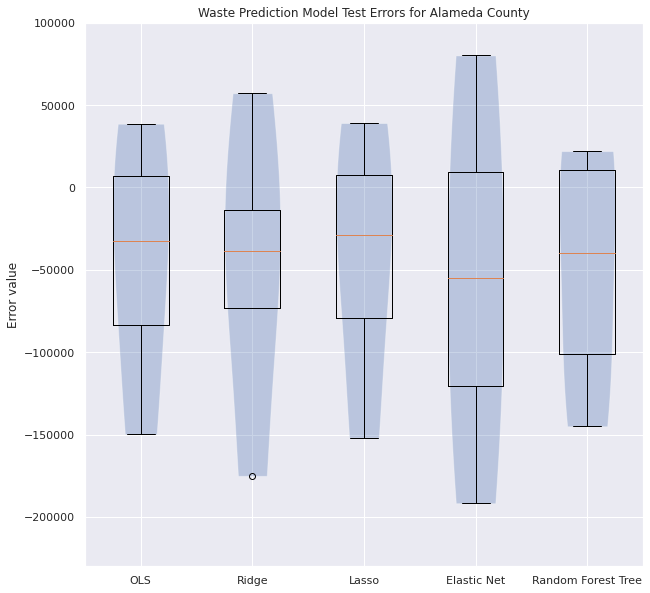

In [ ]:
data = [ols_res_alameda,ridge_res_alameda,lasso_res_alameda,en_res_alameda,rf_tree_res_alameda]

fig, ax = plt.subplots(figsize=(10,10))

ax.set_title('Waste Prediction Model Test Errors for Alameda County')
ax.set_ylabel('Error value')
xticklabels=['OLS','Ridge', 'Lasso', 'Elastic Net','Random Forest Tree']
ax.set_xticklabels(xticklabels)
plt.ylim(-0.23*10**6,0.1*10**6)
ax.boxplot(data, autorange=False)
ax.violinplot(data, showextrema=False)
plt.show()

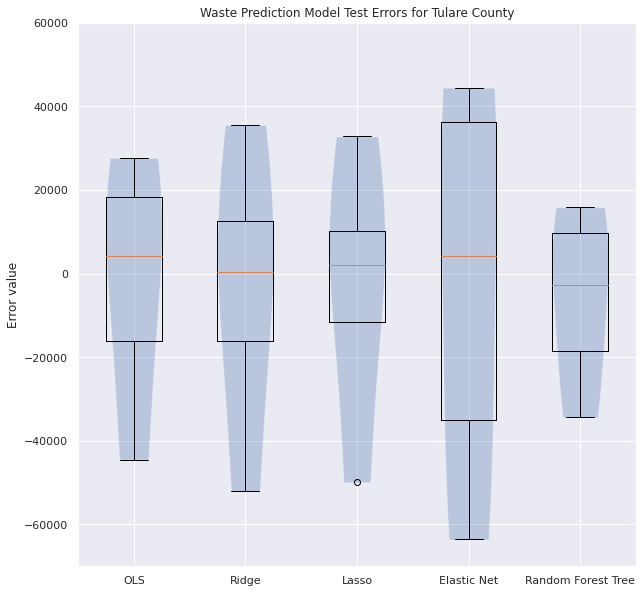

In [ ]:
data = [ols_res_tulare,ridge_res_tulare,lasso_res_tulare,en_res_tulare,rf_tree_res_tulare]

fig, ax = plt.subplots(figsize=(10,10))

ax.set_title('Waste Prediction Model Test Errors for Tulare County')
ax.set_ylabel('Error value')
xticklabels=['OLS','Ridge', 'Lasso', 'Elastic Net','Random Forest Tree']
ax.set_xticklabels(xticklabels)
plt.ylim(-0.07*10**6,0.06*10**6)
ax.boxplot(data, autorange=False)
ax.violinplot(data, showextrema=False)
plt.show()

Based on the violin plot, each of the models used seem to have relatively similar distributions. For both Alameda and Tulare counties, Elastic Net has the widest distribution, implying it has the highest variance. For Alameda, Ridge has a significant outlier, while in Tulare county, Lasso has a significant outlier.

The following code plots the actual vs. predicted waste generation for the Alameda/Tulare data sets and the test data for each of the models.

Alameda County

In [ ]:
def plot_model_prediction_alameda(model, X, y, label):
  model.fit(X_train_alameda, y_train_alameda.values.ravel())
  y_pred = model.predict(X)
  plt.scatter(y_pred,y, label = label, alpha = 0.5)

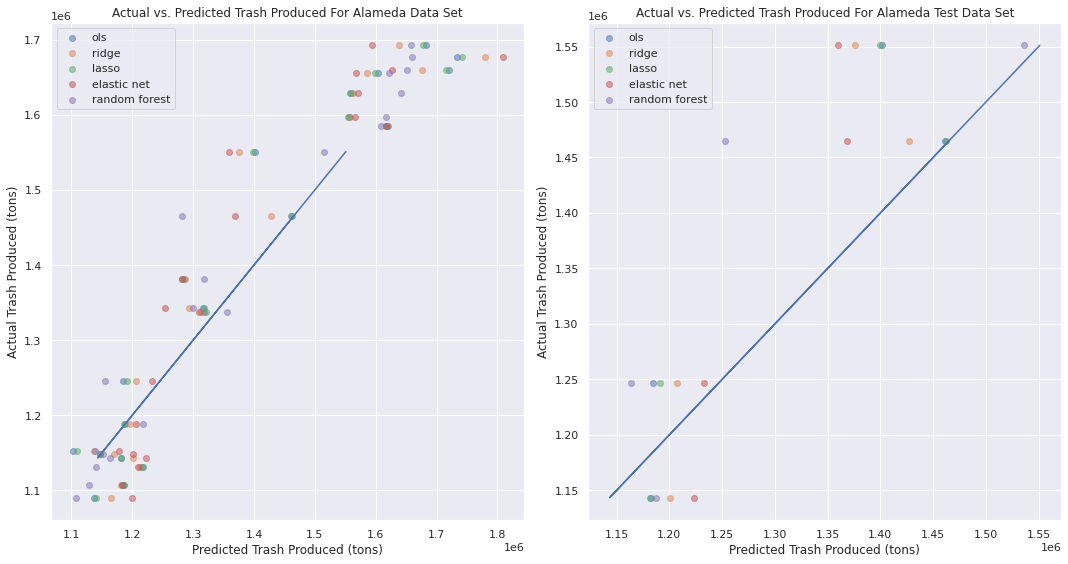

In [ ]:
models = {'ols': ols, 'ridge': ridge, 'lasso': lasso, 'elastic net': en, 'random forest': best_rf_model_alameda }

plt.figure(figsize=(15,8))
#plotting the actual vs. predicted values for each model predicting on the full data set
plt.subplot(121)
for model in models.keys():
  plot_model_prediction_alameda(models[model], alameda_feature_df, alameda_target, model)
plt.legend()
plt.plot(y_test_alameda, y_test_alameda)
plt.xlabel('Predicted Trash Produced (tons)')
plt.ylabel('Actual Trash Produced (tons)')
plt.title('Actual vs. Predicted Trash Produced For Alameda Data Set');

#plotting actual v. predicted models predicting on the test data set
plt.subplot(122)
for model in models.keys(): 
  plot_model_prediction_alameda(models[model], X_test_alameda, y_test_alameda,model)

plt.legend()
plt.plot(y_test_alameda, y_test_alameda)
plt.xlabel('Predicted Trash Produced (tons)')
plt.ylabel('Actual Trash Produced (tons)')
plt.title('Actual vs. Predicted Trash Produced For Alameda Test Data Set')
plt.tight_layout()
plt.show();

Tulare County

In [ ]:
def plot_model_prediction_tulare(model, X, y, label):
  model.fit(X_train_tulare, y_train_tulare.values.ravel())
  y_pred = model.predict(X)
  plt.scatter(y_pred,y, label = label, alpha = 0.5)

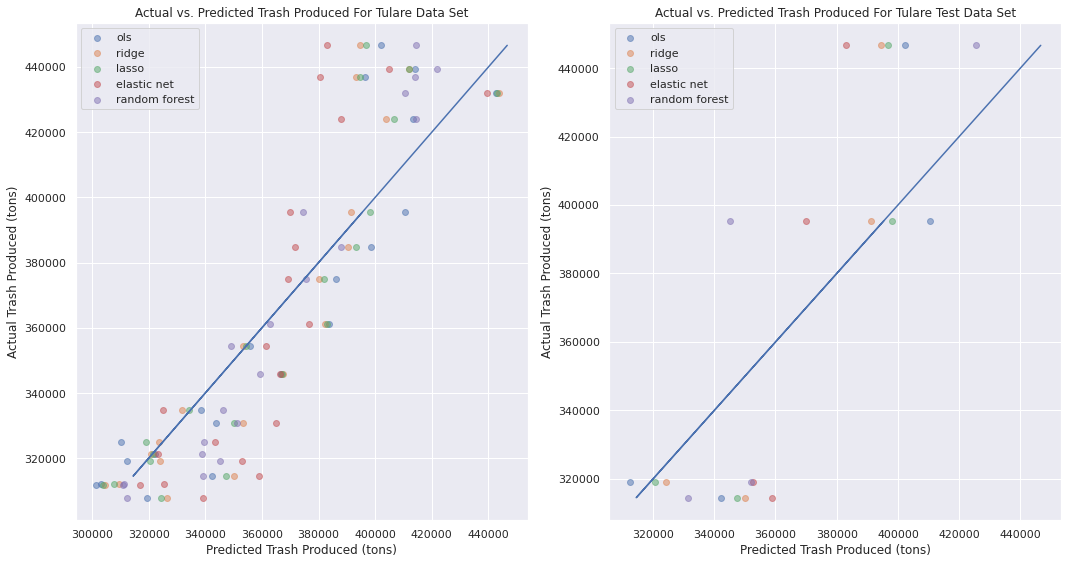

In [ ]:
models = {'ols': ols, 'ridge': ridge, 'lasso': lasso, 'elastic net': en, 'random forest': best_rf_model_tulare }

plt.figure(figsize=(15,8))
#plotting the actual vs. predicted values for each model predicting on the full data set
plt.subplot(121)
for model in models.keys():
  plot_model_prediction_tulare(models[model], tulare_feature_df, tulare_target, model)
plt.legend()
plt.plot(y_test_tulare, y_test_tulare)
plt.xlabel('Predicted Trash Produced (tons)')
plt.ylabel('Actual Trash Produced (tons)')
plt.title('Actual vs. Predicted Trash Produced For Tulare Data Set');

#plotting actual v. predicted models predicting on the test data set
plt.subplot(122)
for model in models.keys(): 
  plot_model_prediction_tulare(models[model], X_test_tulare, y_test_tulare,model)

plt.legend()
plt.plot(y_test_tulare, y_test_tulare)
plt.xlabel('Predicted Trash Produced (tons)')
plt.ylabel('Actual Trash Produced (tons)')
plt.title('Actual vs. Predicted Trash Produced For Tulare Test Data Set')
plt.tight_layout()
plt.show();

For both Alameda and Tulare counties, all of the models seem to perform relatively similarly. In general, the models seem to perform more consistently on a smaller set of data (i.e. one county) than on the entire dataset. That being said, it is difficult to draw any conclusions on these test dataset visualizations, because they are so small. Additionally, Alameda tends to be over-estimated at middle values, while Tulare tends to be under-estimated at middle values.

Elastic net clearly perform the worst - it doesn't seem to be as linear of a relationship and over-predicts pretty consistently.

## Using best model to predict waste generated by Alameda and Tulare

To show how the model performs, we plotted the predicted waste generation for Alameda and Tulare county each year against the observed values of waste generation. These predictions can be directly compared to the predictions/visualizations at the end of Part 1.

In [ ]:
best_model = lasso

In [ ]:
best_model.fit(alameda_feature_df, alameda_target.values.ravel())
alameda_county_df["Predicted Waste Produced"] = best_model.predict(alameda_feature_df)
alameda_county_df.reset_index(inplace=True)
alameda_county_df.rename(columns={"Waste Produced (Tons)": "Observed Waste Produced"}, inplace=True)
alameda_predictions_observations = alameda_county_df[["Year", "County", "Observed Waste Produced", "Predicted Waste Produced"]]

best_model.fit(tulare_feature_df, tulare_target.values.ravel())
tulare_county_df["Predicted Waste Produced"] = best_model.predict(tulare_feature_df)
tulare_county_df.reset_index(inplace=True)
tulare_county_df.rename(columns={"Waste Produced (Tons)": "Observed Waste Produced"}, inplace=True)
tulare_predictions_observations = tulare_county_df[["Year", "County", "Observed Waste Produced", "Predicted Waste Produced"]]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

In [ ]:
def generate_prediction_plot(df, county):
    """Generates plotly line chart for a given county depicting observed waste trends
    and predicted values
    """
    county_preds_obs = county_preds_obs = df[df.County == county]
    observations = county_preds_obs["Observed Waste Produced"]
    predictions = county_preds_obs["Predicted Waste Produced"]

    fig = go.FigureWidget(data=[
      go.Scatter(x=county_preds_obs.Year, y=observations, 
                  mode='lines', line={'dash': 'solid'}, name="Observed"),
      go.Scatter(x=county_preds_obs.Year, y=predictions, 
                  mode='lines', line={'dash': 'dash'}, name="Predicted")
    ])
    fig.update_xaxes(title_text='Year')
    fig.update_yaxes(title_text='Waste Produced (Tons)')
    fig.update_layout(title=county + " County Observed and Predicted Values")
    return fig

In [ ]:
fig = generate_prediction_plot(alameda_predictions_observations, "Alameda")
fig.show()

In [ ]:
fig = generate_prediction_plot(tulare_predictions_observations, "Tulare")
fig.show()

## Comparison of predictions based on the full dataset vs. subsets of the data 

The predictions made in Part 1 seemed to be less accurate than predictions made in Part 2. While the Alameda predictions are very similar for Parts 1 and 2, the predictions made for Tulare are much more accurate (closely following the observed trends) in Part 2. 

It seems that the predictions may be more accurate when based only on data from a given county, but the model may be overfit and less helpful when making predictions into the future.

# Error Analysis

**The pros and cons of modeling on small subsets of data**

* Smaller subsets of data seem to provide more consistency across modeling types. 
* Smaller subsets of data require less computational time for each individual function to run.
* Smaller subsets of data generally produce smaller MAEs. 
* Smaller subsets of data may make it more difficult to draw logical conclusions if the models have large variance and not enough data points to compensate.
* Smaller subsets of data may be more prone to overfitting.
* It takes longer to model each individual subset of data separately, than to train and test on one larger set of data with a single model.

# Part 3: Forecasting waste generation into the future

It's great to see how different kinds of models can predict waste generation over the course of a year, but these predictions don't tell us anything about the future. We now know that Random Forests is best for making predictions on a larger dataset, like our full dataset including all 57 California counties, and Lasso is best for making predictions on smaller datasets, like information about one individual California county. 

Let's use this foundational knowledge to predict waste generation in a given county for a future timepoint. In Part 3 of our project, we will forecaste waste production for Alameda and Tulare counties in the year 2020.

##Load the data

In [2]:
complete_feature_df = pd.read_csv(DATA_PATH + "complete_feature_df.csv")
complete_feature_df.set_index("Year", inplace=True)
complete_feature_df.head()

Waste Produced (Tons)  ... Single Family (units)
Year                           ...                      
2000.0             1676429.25  ...                328399
2000.0                 745.00  ...                   883
2000.0               41059.90  ...                 12563
2000.0              203896.87  ...                 53845
2000.0               34110.44  ...                 19777

[5 rows x 8 columns]

##"Lag" the data

In order to make predictions into the future, our features must "lag" n-1 years. The following function restructures an input dataframe so that the features properly lag to correspond with the correct year to make accurate predictions.

In [3]:
def forecast_preprocessing(feature_df, county):
    """Aligns year n-1 features with year n.  e.g. 2019 waste produced should go with 2018 features
    """
    county_df = feature_df.loc[feature_df["County"] == county]
    
    target = county_df[["Waste Produced (Tons)"]]
    feature_df = county_df.drop(columns="Waste Produced (Tons)")
    
    # shift features down a year
    shifted_feature_df = feature_df.shift(-1)
    shifted_feature_df.dropna(how="all", inplace=True)
    shifted_feature_df.drop(columns=["County"], inplace=True)
    
    # "shift" target by dropping earliest year
    min_year = target.index.min()
    target = target.drop(min_year)
    
    assert len(target) == len(shifted_feature_df), "Length of features and target need to be equal"
    
    return shifted_feature_df, target

In [4]:
alameda_features, alameda_target = forecast_preprocessing(complete_feature_df, "Alameda")

In [5]:
tulare_features, tulare_target = forecast_preprocessing(complete_feature_df, "Tulare")

##Check the faithfulness of the altered data

In [6]:
alameda_features.tail(2)

Population  ...  Single Family (units)
Year                ...                       
2017.0   1655306.0  ...               363747.0
2018.0   1664783.0  ...               365797.0

[2 rows x 6 columns]

In [7]:
tulare_features.tail(2)

Population  ...  Single Family (units)
Year                ...                       
2017.0    472915.0  ...               117169.0
2018.0    476588.0  ...               118137.0

[2 rows x 6 columns]

Check to ensure 2019 has been dropped from the features dataframe, and the features have been properly shifted, and the lag has been accounted for.

In [8]:
alameda_target.tail(2)

Waste Produced (Tons)
Year                         
2018.0             1342490.34
2019.0             1465263.51

In [9]:
tulare_target.tail(2)

Waste Produced (Tons)
Year                         
2018.0               423906.9
2019.0               446633.6

2019 *should* be included in the target variable dataframe, seeing as this is the value we are predicting.

In [10]:
max_feature_year = alameda_features.index.max()
max_target_year = alameda_target.index.max()
print(max_feature_year, max_target_year)

2018.0 2019.0


In [11]:
max_feature_year_t = tulare_features.index.max()
max_target_year_t = tulare_target.index.max()
print(max_feature_year_t, max_target_year_t)

2018.0 2019.0


##Train, Test Split of the data

In [12]:
X_train_alameda, y_train_alameda = alameda_features.loc[alameda_features.index!=max_feature_year], alameda_target[alameda_target.index!=max_target_year]
X_test_alameda, y_test_alameda = alameda_features.loc[alameda_features.index==max_feature_year], alameda_target[alameda_target.index==max_target_year]

assert 2019 not in X_train_alameda.index.unique(), f"{max_target_year} should not be in the training data"
assert 2019 == y_test_alameda.index.unique(), f"{max_target_year} should be the test data"

In [13]:
X_train_tulare, y_train_tulare = tulare_features.loc[tulare_features.index!=max_feature_year_t], tulare_target[tulare_target.index!=max_target_year_t]
X_test_tulare, y_test_tulare = tulare_features.loc[tulare_features.index==max_feature_year_t], tulare_target[tulare_target.index==max_target_year_t]

assert 2019 not in X_train_tulare.index.unique(), f"{max_target_year_t} should not be in the training data"
assert 2019 == y_test_tulare.index.unique(), f"{max_target_year_t} should be the test data"

These assert statements allowed us to be sure our data processing was carried out correctly.

#Linear regression methods

We will now carry out the same evaluation of the best model to use as we did in Part 1 and Part 2. This evaluation will tell us which model is most effecive when forecasting waste generation. Models will be evaluating the lagged datasets for both Alameda and Tulare which have been split into 80% 20% train, test splits. Since the datasets are small, we will be using score_cv_model_2 which implements LOOCV rather than k-fold CV. 

Alameda Scores

In [25]:
ols_score_alameda, ols = score_cv_model_2(LinearRegression, X_train_alameda, y_train_alameda, X_test_alameda, y_test_alameda, 0)
ridge_score_alameda, ridge = score_cv_model_2(Ridge, X_train_alameda, y_train_alameda, X_test_alameda, y_test_alameda, ridge_alphas) #correcting for the negative absolute error
lasso_score_alameda, lasso = score_cv_model_2(Lasso, X_train_alameda, y_train_alameda, X_test_alameda, y_test_alameda, lasso_alphas) #correcting for the negative absolute error
en_score_alameda, en = score_cv_model_2(ElasticNet, X_train_alameda, y_train_alameda, X_test_alameda, y_test_alameda, en_alphas) #correcting for the negative absolute error

print('cv ols score for Alameda county: ', ols_score_alameda)
print('cv ridge score for Alameda county: ', ridge_score_alameda)
print('cv lasso score for Alameda county: ', lasso_score_alameda)
print('cv elastic net score for Alameda county:', en_score_alameda)

Ridge(alpha=0.007, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=None, solver='auto', tol=1e-05)
Lasso(alpha=49, copy_X=True, fit_intercept=True, max_iter=100000,
      normalize=True, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.99,
           max_iter=100000, normalize=True, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
cv ols score for Alameda county:  197778.1885981392
cv ridge score for Alameda county:  118061.9353046099
cv lasso score for Alameda county:  171305.64901373998
cv elastic net score for Alameda county: 124213.24228840652


In [32]:
random_forest_model = RandomForestRegressor()

possible_hyperparams = { 
    'n_estimators': [25, 50],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,10)]
}

grid_search = GridSearchCV(estimator=random_forest_model, param_grid=possible_hyperparams, cv=5, scoring='neg_mean_absolute_error')

grid_search.fit(X_train_alameda, y_train_alameda.values.ravel()) # need to call this ravel function because of https://stackoverflow.com/questions/34165731/a-column-vector-y-was-passed-when-a-1d-array-was-expected
best_score = -grid_search.best_score_ # needs to be negated because of https://stackoverflow.com/questions/21443865/scikit-learn-cross-validation-negative-values-with-mean-squared-error
best_rf_model_alameda = grid_search.best_estimator_
print(best_score, best_rf_model_alameda)

85816.07122333316 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)


## Compare Final Models

In [29]:
def model_test_score(model, X_train, y_train, X_test, y_test):
  model.fit(X_train, y_train.values.ravel())
  y_pred = model.predict(X_test)

  residual = y_pred - y_test.to_numpy().flatten()
  mae = mean_absolute_error(y_test,y_pred)

  return mae, residual, y_pred

Compare best Linear Regression & Decision tree model for Alameda 



In [33]:
ridge_test_alameda, ridge_res_alameda, ridge_y_alameda = model_test_score(ridge, X_train_alameda, y_train_alameda, X_test_alameda, y_test_alameda)
rf_tree_test_alameda, rf_tree_res_alameda, rf_tree_y_alameda = model_test_score(best_rf_model_alameda, X_train_alameda, y_train_alameda, X_test_alameda, y_test_alameda)

print('ridge test score for Alameda county: ', ridge_test_alameda)
print('random forest tree test score for Alameda county: ', rf_tree_test_alameda)

ridge test score for Alameda county:  19397.847663404653
random forest tree test score for Alameda county:  135466.9255999988


Tulare MAE, Residual, y_pred

In [34]:
# ols_test_tulare, ols_res_tulare, ols_y_tulare = model_test_score(ols, X_train_tulare, y_train_tulare, X_test_tulare, y_test_tulare)
# ridge_test_tulare, ridge_res_tulare, ridge_y_tulare = model_test_score(ridge, X_train_tulare, y_train_tulare, X_test_tulare, y_test_tulare)
# lasso_test_tulare, lasso_res_tulare, lasso_y_tulare = model_test_score(lasso, X_train_tulare, y_train_tulare, X_test_tulare, y_test_tulare)
# en_test_tulare, en_res_tulare, en_y_tulare = model_test_score(en, X_train_tulare, y_train_tulare, X_test_tulare, y_test_tulare)
# rf_tree_test_tulare, rf_tree_res_tulare, rf_tree_y_tulare = model_test_score(best_rf_model_tulare, X_train_tulare, y_train_tulare, X_test_tulare, y_test_tulare)

# print('ols test score for Tulare county: ', ols_test_tulare)
# print('ridge test score for Tulare county: ', ridge_test_tulare)
# print('lasso test score for Tulare county: ', lasso_test_tulare)
# print('elastic net test score for Tulare county: ', en_test_tulare)
# print('random forest tree test score for Tulare county: ', rf_tree_test_tulare)

In [38]:
def get_features_county_year(df, county, year):
    """Get features for a particular county and year without target variable
    """
    county_filter = df.County == county
    year_filter = df.index == year
    county_year = complete_feature_df.loc[county_filter & year_filter]
    county_year_features = county_year.drop(columns=["Waste Produced (Tons)", "County"])
    return county_year_features

In [39]:
alameda_2019_features = get_features_county_year(complete_feature_df, "Alameda", 2019)
alameda_2019_features

Population  ...  Single Family (units)
Year                ...                       
2019.0   1664783.0  ...                 365797

[1 rows x 6 columns]

In [40]:
alameda_predicted = best_forecast_model.predict(alameda_2019_features)
alameda_predicted

array([1445865.6623366])

In [41]:
def forecast_plot(county, observed, predicted):

    max_year = 2019 # alameda_target.index.max()
    observed.loc[max_year+1] = predicted
    
    observations = observed[observed.index <= max_year]
    predictions = observed[observed.index >= max_year]
    
    fig = go.FigureWidget(data=[
        go.Scatter(x=predictions.index, y=predictions["Waste Produced (Tons)"], 
               mode='lines+markers', line={'dash': 'solid', 'color': 'red'}, name="Predicted"),
        go.Scatter(x=observations.index, y=observations["Waste Produced (Tons)"], 
               mode='lines+markers', line={'dash': 'solid', 'color': 'blue'}, name="Observed")
    ])
    
    fig.update_xaxes(title_text='Year')
    fig.update_yaxes(title_text='Waste Produced (Tons)')
    fig.update_layout(title=county + " Forecasted Prediction")
    
    return fig

In [42]:
fig = forecast_plot("Alameda", alameda_target, alameda_predicted)
fig.show()

In [ ]:
# tulare_features, tulare_target = forecast_preprocessing(complete_feature_df, "Tulare")
# tulare_features.tail(2)
# tulare_target.tail(2)
# max_feature_year_t = tulare_features.index.max()
# max_target_year_t = tulare_target.index.max()
# print(max_feature_year_t, max_target_year_t)
# X_train_tulare, y_train_tulare = tulare_features.loc[tulare_features.index!=max_feature_year_t], tulare_target[tulare_target.index!=max_target_year_t]
# X_test_tulare, y_test_tulare = tulare_features.loc[tulare_features.index==max_feature_year_t], tulare_target[tulare_target.index==max_target_year_t]

# assert 2019 not in X_train_tulare.index.unique(), f"{max_target_year_t} should not be in the training data"
# assert 2019 == y_test_tulare.index.unique(), f"{max_target_year_t} should be the test data"

# ols_score_tulare, ols = score_cv_model_2(LinearRegression, X_train_tulare, y_train_tulare, X_test_tulare, y_test_tulare, 0)
# ridge_score_tulare, ridge = score_cv_model_2(Ridge, X_train_tulare, y_train_tulare, X_test_tulare, y_test_tulare,ridge_alphas) #correcting for the negative absolute error
# lasso_score_tulare, lasso = score_cv_model_2(Lasso, X_train_tulare, y_train_tulare, X_test_tulare, y_test_tulare, lasso_alphas) #correcting for the negative absolute error
# en_score_tulare, en = score_cv_model_2(ElasticNet, X_train_tulare, y_train_tulare, X_test_tulare, y_test_tulare, en_alphas) #correcting for the negative absolute error

# print('cv ols score for Tulare county: ',ols_score_tulare)
# print('cv ridge score for Tulare county: ', ridge_score_tulare)
# print('cv lasso score for Tulare county: ', lasso_score_tulare)
# print('cv elastic net score for Tulare county:', en_score_tulare)

##Part 3 Error Analysis / Summary

[insert text]

##1.9 Interpretation and Conclusions

**In this section you must relate your modeling and forecasting results to your original prediction question. Discuss caveats and / or reasons your results might be flawed.**